# Import Packages, Functions and Data

In [1]:
import titanlib
import geopandas
import pandas as pd
import netCDF4
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import time

In [2]:
import titanlibcustom

In [3]:
# Import Formatted Data and functions from other Python script
from Data_Importation_and_Function_Definition import ROI_counties, NI_counties, rain_wow, rain_wow_hourly_obs, temp_wow, rain_official, temp_official, isolate_data_of_interest, plot_wow_data

# Obtain Test Data

In [4]:
gdf_temp_wow, gdf_temp_official, gdf_temp_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_data="Temperature", 
                                                                              add_elevation_bool=True,
                                                                              remove_missing_val=True, 
                                                                              cols_to_remove_missing_val=["Air Temperature"])

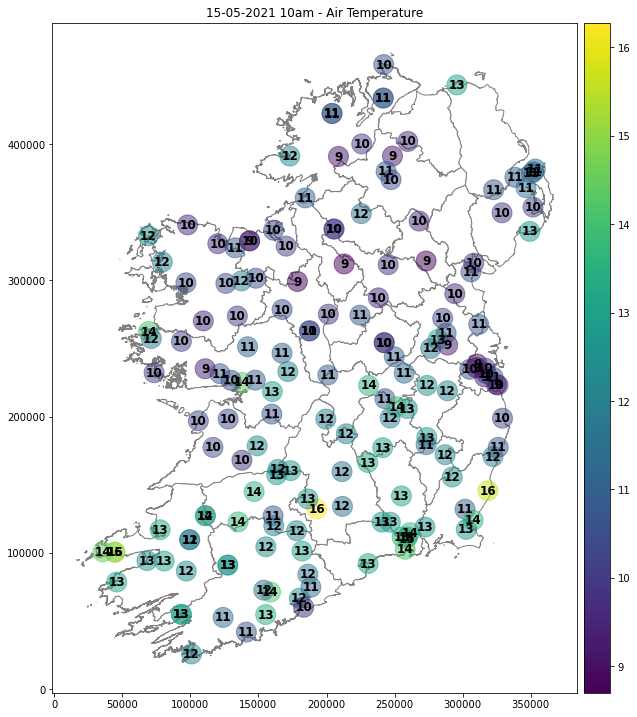

In [5]:
plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = None)

In [6]:
# By default let's discard any missing data from Rainfall Accumulation or Rainfall Accumulation Hourly
# Note we cannot yet discard from Rainfall Rate as we do not have the official Rainfall Rate
gdf_rain_wow, gdf_rain_official, gdf_rain_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_data="Rainfall", 
                                                                              add_elevation_bool=True,
                                                                              remove_missing_val=True, 
                                                                              cols_to_remove_missing_val=["Rainfall Accumulation", "Rainfall Accumulation Hourly"])

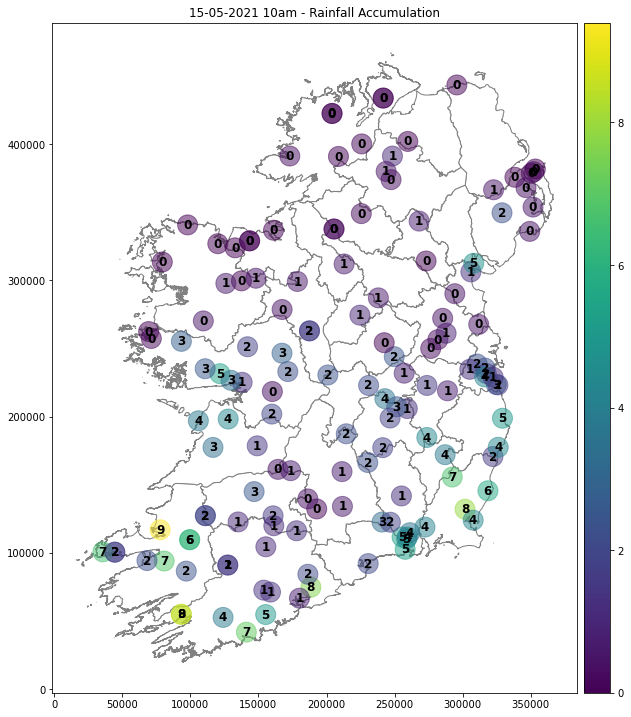

In [7]:
plot_wow_data(gdf_of_interest = gdf_rain_combined, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 0, flags = None)

# Isolation Check

In [8]:
long_np = np.array(gdf_temp_combined["Longitude"])
lat_np = np.array(gdf_temp_combined["Latitude"])

points = titanlib.Points(lat_np, long_np)

In [9]:
radius = 15000 # Radius around each station to check
num_min = 3 # Minimum number of 

radius2 = 50000
num_min2 = 1

flags = titanlib.isolation_check(points, num_min, radius) # more strict requirements
flags2 = titanlib.isolation_check(points, num_min2, radius2) # very lenient requirements

print(flags)
print("\n")
print(flags2)

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1
 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
custom_points = titanlibcustom.Points(lat_np, long_np)

custom_flags = titanlibcustom.isolation_check(custom_points, num_min, radius)
custom_flags2 = titanlibcustom.isolation_check(custom_points, num_min2, radius2)

print(custom_flags) 
print("\n")
print(custom_flags2) 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [11]:
# plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
#               buffer_val = 50000, flags = flags2)

# Range Check

## range_check

In [12]:
np_values = np.array(gdf_temp_combined["Air Temperature"]) # Values you want to check Rainfall/Temp

# We have the choice between defining a global min and max
# Or defining individual min and max values for each station
# (potential use case: Checking measurement is within the ranges of the stations sensor)

global_min = np.array([10.0]) 
global_max = np.array([15.0])

rng = np.random.default_rng(42)
random_min = rng.integers(low = 0, high = 15, size=len(np_values))
random_max = random_min + 10

In [13]:
flags = titanlib.range_check(np_values, global_min, global_max)
flags

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [14]:
# plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
#               buffer_val = 0, flags = flags)

In [15]:
random_flags = titanlib.range_check(np_values, random_min, random_max)
random_flags

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [16]:
# plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
#               buffer_val = 0, flags = random_flags)

## range_check_climatology

In [17]:
long_np = np.array(gdf_temp_combined["Longitude"])
lat_np = np.array(gdf_temp_combined["Latitude"])

points = titanlib.Points(lat_np, long_np) # Location of each station observation

np_values = np.array(gdf_temp_combined["Air Temperature"]) # Values you want to check Rainfall/Temp


dt = datetime.datetime(year = 2021, month = 5, day = 15, hour = 10)
date_time_of_int = int(time.mktime(dt.timetuple())) # date and time of interest in UNIX integer format


# We have the choice between defining a global neg and pos
# Or defining individual min and max values for each station

pos_above_mean = np.array([2.5]) # Value above the mean climatological value to accept
neg_below_mean = np.array([-2.5]) # Value above the mean climatological value to accept

In [18]:
flags = titanlib.range_check_climatology(points, np_values, date_time_of_int, pos_above_mean, neg_below_mean)
flags

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [19]:
# Note the code for titanlibcustom has been adjusted to return the mean temperature rather than the flag
custom_points = titanlibcustom.Points(lat_np, long_np)


dt = datetime.datetime(year = 2021, month = 5, day = 15, hour = 10)
date_time_of_int = int(time.mktime(dt.timetuple())) # date and time of interest in UNIX integer format

custom_flags = titanlibcustom.range_check_climatology(custom_points, np_values,  date_time_of_int, 
                                                      pos_above_mean, neg_below_mean)
print(custom_flags)


dt = datetime.datetime(year = 2021, month = 12, day = 15, hour = 10) # What if it was Winter instead?
date_time_of_int = int(time.mktime(dt.timetuple())) # date and time of interest in UNIX integer format

custom_flags_winter = titanlibcustom.range_check_climatology(custom_points, np_values,  date_time_of_int,
                                                             pos_above_mean, neg_below_mean)
print(custom_flags_winter)

[12 12 11 12 11 12 13 12 12 11 12 12 11 12 12 11 12 12 11 12 11 12 11 11
 11 12 11 11 11 12 12 12 12 12 12 12 12 12 12 12 11 11 11 12 13 12 12 12
 12 12 12 12 12 12 12 12 12 12 11 13 12 12 12 12 12 12 11 12 12 11 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 11 13 12 12 12 13 12
 12 12 12 12 12 12 12 12 11 12 12 12 12 12 12 12 12 12 11 12 12 12 12 12
 11 12 12 13 12 13 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 11 12 12
 12 11 11 11 11 12 12 12 12 13 12 12 12 12 12 12 12 12 11 11 11 11]
[ 0  0  0  0  0  0  1  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  1  1
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  1  0  0  0  1  1
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  1  0  0  

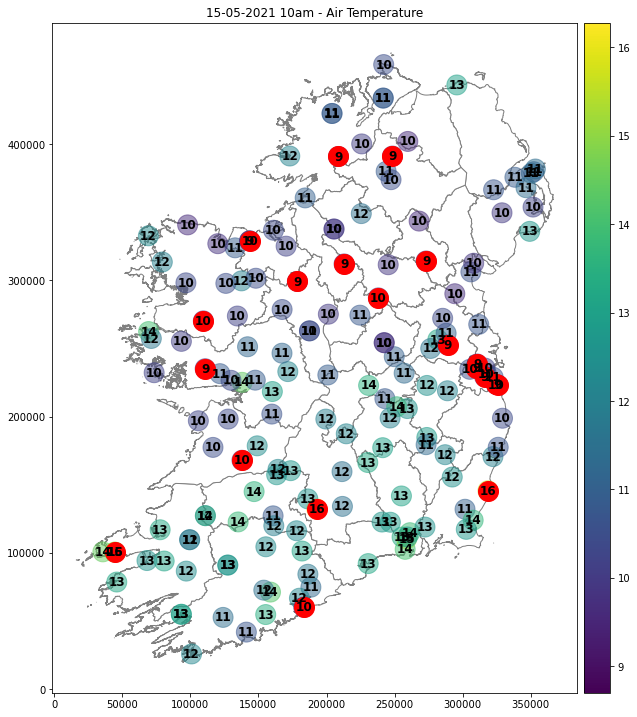

In [20]:
plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = flags)

In [21]:
test_gdf = gdf_temp_combined.copy()

test_gdf["Mean Temp"] = custom_flags
test_gdf["Winter Mean Temp"] = custom_flags_winter

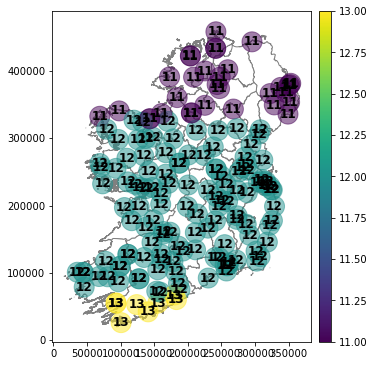

In [22]:
ax = ROI_counties["geometry"].plot(figsize=(5,8), edgecolors="grey", color="w")
divider = make_axes_locatable(ax) # for vertically aligning the plot and the legend
NI_counties["geometry"].plot(ax=ax, edgecolors="grey", color="w")  

cax = divider.append_axes("right", size="5%", pad=0.1)



##### Plot Markers #####
test_gdf.plot("Mean Temp", ax=ax, legend = True, cax=cax, markersize=400, alpha = 0.5)

# Annotate each marker with the Rainfall Accumulation to the nearest whole number
for x, y, label in zip(test_gdf.geometry.x, test_gdf.geometry.y, test_gdf["Mean Temp"]):
    ax.annotate(round(label), xy=(x, y), verticalalignment='center', horizontalalignment='center', 
                weight = "bold", fontsize = "large")

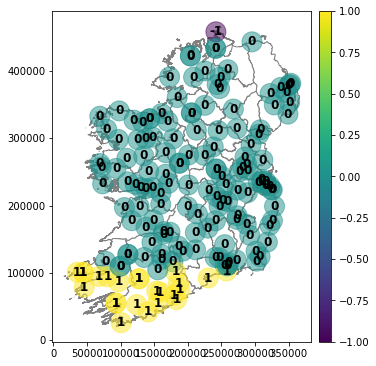

In [23]:
ax = ROI_counties["geometry"].plot(figsize=(5,8), edgecolors="grey", color="w")
divider = make_axes_locatable(ax) # for vertically aligning the plot and the legend
NI_counties["geometry"].plot(ax=ax, edgecolors="grey", color="w")  

cax = divider.append_axes("right", size="5%", pad=0.1)



##### Plot Markers #####
test_gdf.plot("Winter Mean Temp", ax=ax, legend = True, cax=cax, markersize=400, alpha = 0.5)

# Annotate each marker with the Rainfall Accumulation to the nearest whole number
for x, y, label in zip(test_gdf.geometry.x, test_gdf.geometry.y, test_gdf["Winter Mean Temp"]):
    ax.annotate(round(label), xy=(x, y), verticalalignment='center', horizontalalignment='center', 
                weight = "bold", fontsize = "large")

# Buddy Checks

## Buddy Event Check

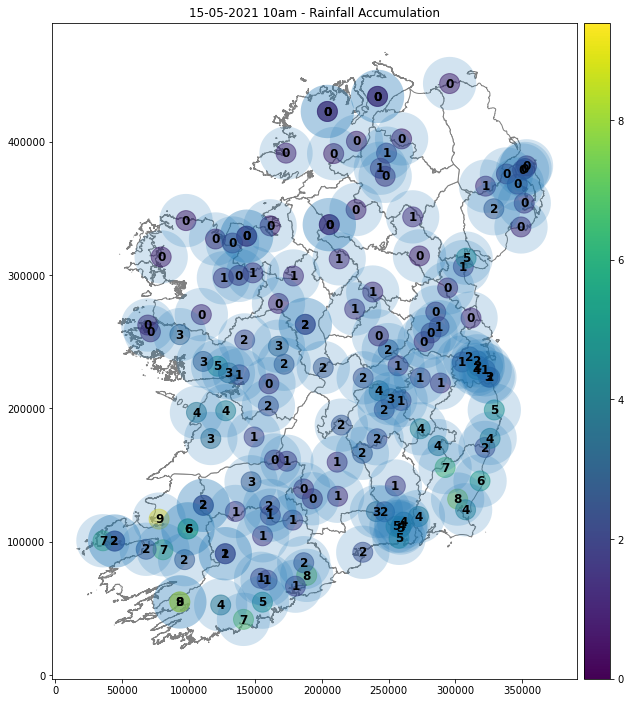

In [24]:
plot_wow_data(gdf_of_interest = gdf_rain_combined, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 20000, flags = None)

In [25]:
long_np = np.array(gdf_rain_combined["Longitude"])
lat_np = np.array(gdf_rain_combined["Latitude"])

points = titanlib.Points(lat_np, long_np) # Location of each station observation

np_values = np.array(gdf_rain_combined["Rainfall Accumulation"]) # Values you want to check Rainfall/Temp



# NOTE: the neighbourhood size I am using is almost certainly not suitable for a check like this
# as legitimate differences should probably be allowed to occur 10+ km away however this is just
# a proof of concept to get a feeling for how the check works

radius = np.full(points.size(), 20000) # Radius of neighbourhood of points to consider
num_min = np.full(points.size(), 3) # Minimum number of neighbours for a valid test (else throw an error)


event_threshold = 0.2 # Threshold above which the event is said to occur (i.e. rain happened)
threshold = 0.25 # Fraction of other observations in the neighbourhood that must agree with the obs being tested
max_elev_diff = 0 # Difference between elevations within the neighbourhood must not exceed this value
elev_gradient = 0 # Value for linearly rescaling values for different elevations (e.g. for temp -0.0065 deg C per m)
num_iterations = 5 # Number of iterations


flags = titanlib.buddy_event_check(points, np_values, radius, num_min, event_threshold, 
                                   threshold, max_elev_diff, elev_gradient, num_iterations)

flags

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

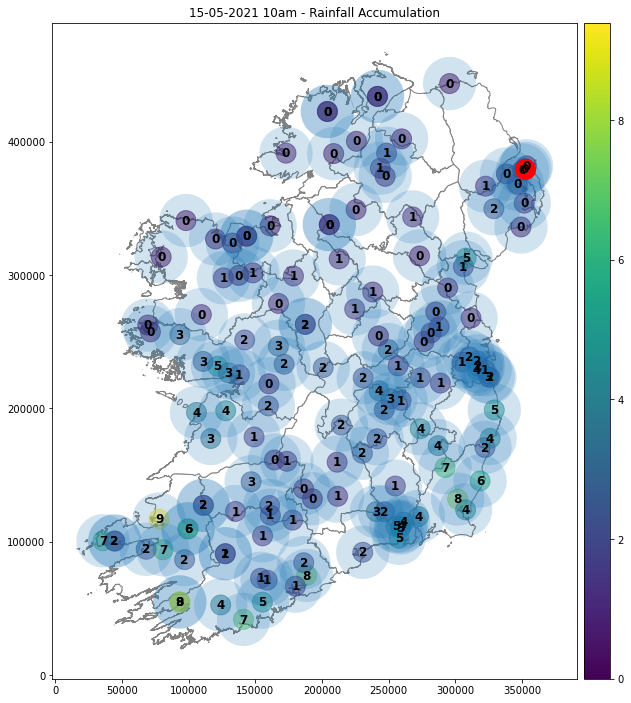

In [26]:
plot_wow_data(gdf_of_interest = gdf_rain_combined, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 20000, flags = flags)

## Buddy Check

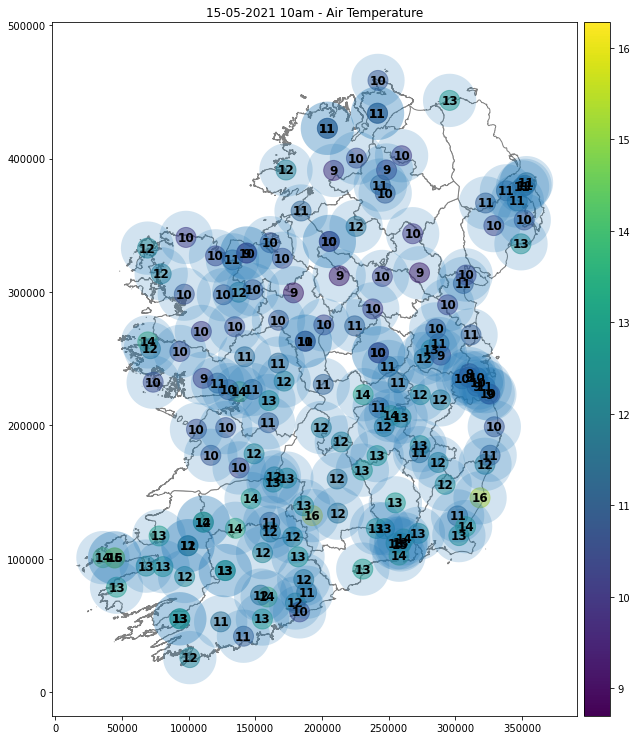

In [27]:
plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = 20000, flags = None)

In [28]:
long_np = np.array(gdf_temp_combined["Longitude"])
lat_np = np.array(gdf_temp_combined["Latitude"])

points = titanlib.Points(lat_np, long_np) # Location of each station observation

np_values = np.array(gdf_temp_combined["Air Temperature"]) # Values you want to check Rainfall/Temp



# NOTE: the neighbourhood size I am using is almost certainly not suitable for a check like this
# as legitimate differences should probably be allowed to occur 10+ km away however this is just
# a proof of concept to get a feeling for how the check works

radius = np.full(points.size(), 40000) # Radius of neighbourhood of points to consider
num_min = np.full(points.size(), 5) # Minimum number of neighbours for a valid test (else throw an error)


# The buddy check flags an observations if |observation - avg of neighbours| normalized by the 
# standard deviation in the circle is greater than a predefined threshold

threshold = 3 # standard deviation threshold for flagging suspicious observations
min_std = 1 # If the sd of observations in the neighbourhood is less than this value use this instead as the check
max_elev_diff = 0 # Difference between elevations within the neighbourhood must not exceed this value
elev_gradient = -0.0065 # Value for linearly rescaling values for different elevations (e.g. for temp -0.0065 deg C per m)
num_iterations = 5 # Number of iterations

flags = titanlib.buddy_check(points, np_values, radius, num_min, threshold, 
                             max_elev_diff, elev_gradient, min_std, num_iterations)
flags

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

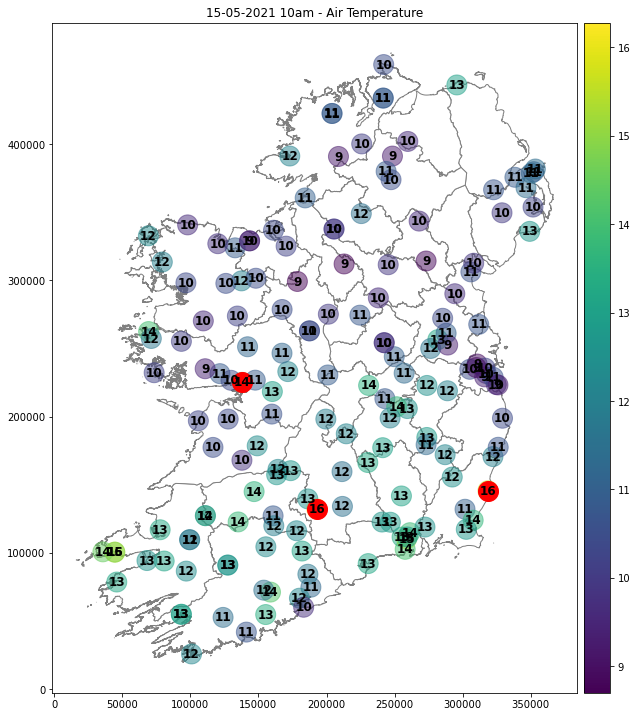

In [29]:
plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = flags)

In [30]:
# Create a data set with some outliers that will hopefully be flagged even with a high threshold

gdf_temp_combined_outliers = gdf_temp_combined.copy()

gdf_temp_combined_outliers.loc[gdf_temp_combined_outliers.index[[0, 1, 2, 3, 4]], ("Air Temperature")] = 30

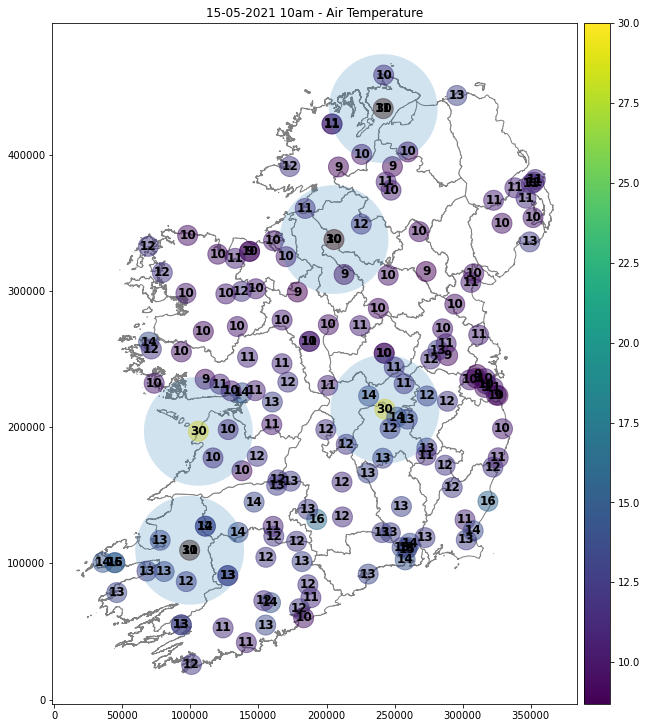

In [31]:
buffer_val_list = np.zeros(len(gdf_temp_combined_outliers), dtype = int)
outliers = [0, 1, 2, 3, 4]
buffer_val_list[outliers] = 40000
buffer_val_list = list(buffer_val_list)


plot_wow_data(gdf_of_interest = gdf_temp_combined_outliers, type_of_plot = "Air Temperature", 
              buffer_val = buffer_val_list, flags = None)

In [32]:
long_np = np.array(gdf_temp_combined_outliers["Longitude"])
lat_np = np.array(gdf_temp_combined_outliers["Latitude"])

points = titanlib.Points(lat_np, long_np) # Location of each station observation

np_values = np.array(gdf_temp_combined_outliers["Air Temperature"]) # Values you want to check Rainfall/Temp



# NOTE: the neighbourhood size I am using is almost certainly not suitable for a check like this
# as legitimate differences should probably be allowed to occur 10+ km away however this is just
# a proof of concept to get a feeling for how the check works

radius = np.full(points.size(), 40000) # Radius of neighbourhood of points to consider
num_min = np.full(points.size(), 5) # Minimum number of neighbours for a valid test (else throw an error)


# The buddy check flags an observations if |observation - avg of neighbours| normalized by the 
# standard deviation in the circle is greater than a predefined threshold

threshold = 5 # standard deviation threshold for flagging suspicious observations
min_std = 1 # If the sd of observations in the neighbourhood is less than this value use this instead as the check
max_elev_diff = 0 # Difference between elevations within the neighbourhood must not exceed this value
elev_gradient = -0.0065 # Value for linearly rescaling values for different elevations (e.g. for temp -0.0065 deg C per m)
num_iterations = 5 # Number of iterations



flags = titanlib.buddy_check(points, np_values, radius, num_min, threshold, 
                             max_elev_diff, elev_gradient, min_std, num_iterations)
flags

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

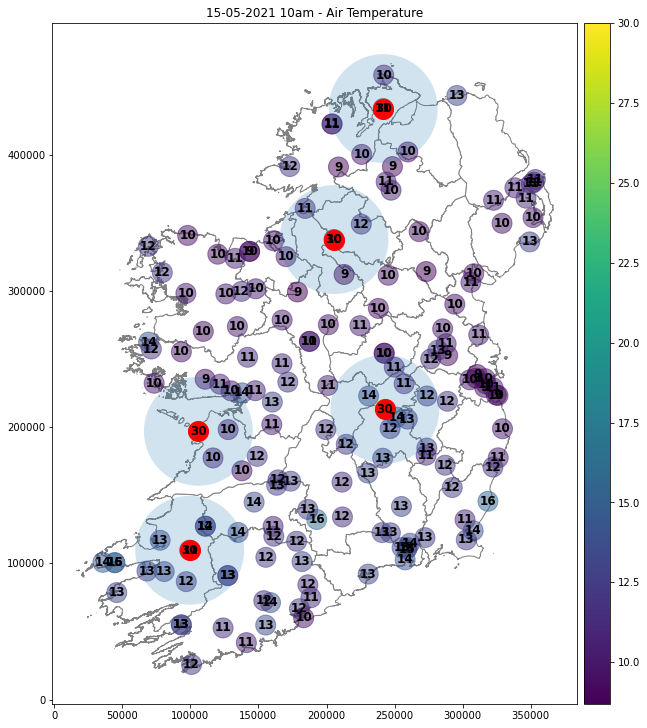

In [33]:
plot_wow_data(gdf_of_interest = gdf_temp_combined_outliers, type_of_plot = "Air Temperature", 
              buffer_val = buffer_val_list, flags = flags)